In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

# Import relevant custom libraries
from src.eda import data_info
from src.evaluation import ValidationEvaluation

# Import relevant libraries
import pandas as pd
import warnings
from IPython.display import display
import matplotlib.pyplot as plt
import math
import os
import glob

# Config
pd.set_option('display.max_columns', None) # Ensure all columns are displayed
warnings.filterwarnings("ignore")

In [2]:
# Read relevant files
X_train = pd.read_feather("../data/processed/X_train.feather")
X_train_validate = pd.read_feather("../data/processed/X_train_validate.feather")

# Get data info
var_info = data_info(X_train)
all_cols = X_train.columns
real_cols = var_info[var_info["var_type"]=="numerical"]["var_name"].tolist()
binary_cols = var_info[var_info["var_type"]=="binary"]["var_name"].tolist()

## 1. Test the trainer

In [3]:
#Failed to train model with config {'hidden_dims': (64, 32), 'batch_size': 101, 'dropout_rate': 0.27635394201074476, 'learning_rate': 0.007191783951237578, 'lam': 0.04916278144991648, 'gamma': 0.7794677063882551, 'l2norm_pct': 83, 'max_epochs': 469}: object of type 'NoneType' has no len()

"""ae = AutoencoderTrainer(
    input_dim=X_train.shape[1],
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    hidden_dims=(64, 32),
    learning_rate=0.007191783951237578,
    dropout_rate=0.27635394201074476,
    lam=0.04916278144991648,
    gamma=0.7794677063882551,
    verbose=True,
    max_epochs=469,
    plot_losses=True,
    dp_sgd=True,
    target_epsilon=0.5,
    delta=1e-5,
    batch_size=101,
    l2norm_pct=83,
    patience_limit=20,
)
autoencoder = ae.train(X_train, X_train_validate)"""

'ae = AutoencoderTrainer(\n    input_dim=X_train.shape[1],\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    hidden_dims=(64, 32),\n    learning_rate=0.007191783951237578,\n    dropout_rate=0.27635394201074476,\n    lam=0.04916278144991648,\n    gamma=0.7794677063882551,\n    verbose=True,\n    max_epochs=469,\n    plot_losses=True,\n    dp_sgd=True,\n    target_epsilon=0.5,\n    delta=1e-5,\n    batch_size=101,\n    l2norm_pct=83,\n    patience_limit=20,\n)\nautoencoder = ae.train(X_train, X_train_validate)'

## 2. Test the anomaly detector

In [4]:
"""# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# After training
detector = AnomalyDetector(
    model=autoencoder,
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    lam=ae.lam,
)

# Compute scores
scores = detector._compute_anomaly_scores(X_validate)

# Detect
threshold = np.quantile(scores, 0.8)
y_pred = detector._detect(scores, threshold)

# Evaluate
metrics = detector._evaluate(y_pred, y_validate, scores)
print(metrics)"""

'# Read relevant files\nX_validate = pd.read_feather("../data/processed/X_validate.feather")\ny_validate = pd.read_feather("../data/processed/y_validate.feather")\n\n# After training\ndetector = AnomalyDetector(\n    model=autoencoder,\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    lam=ae.lam,\n)\n\n# Compute scores\nscores = detector._compute_anomaly_scores(X_validate)\n\n# Detect\nthreshold = np.quantile(scores, 0.8)\ny_pred = detector._detect(scores, threshold)\n\n# Evaluate\nmetrics = detector._evaluate(y_pred, y_validate, scores)\nprint(metrics)'

## 3. Hyperparameter Tuning

### 3.1. Tuning Implementation

In [5]:
# Epsilon = 1
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=50 --epsilon 1 --delta 1e-5
# Epsilon = 3
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=30 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=40 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=40 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=50 --epsilon 3 --delta 1e-5
# Epsilon = 5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=30 --epsilon 5 --delta 1e-5

### 3.2. Summarize the Performance on Validation Set

In [6]:
# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# Initialize the validation evaluation
valeval = ValidationEvaluation(X_validate, y_validate, real_cols, binary_cols, all_cols, dp_sgd=True)
    
# Read the log file
log_path = "../logs/dpsgd_tune_log.txt"

# Extract the latest successful Bayesian versions
latest_successful_versions = valeval.extract_latest_successful_bayesian_versions(log_path)
print(latest_successful_versions)

# Evaluate the model performance
eval_results = valeval.evaluate_model_performance(latest_successful_versions)
eval_results = eval_results[eval_results["epsilon"]>=1]

{'202505070326': ('AUC', 1.0, 1e-05, datetime.datetime(2025, 5, 8, 20, 40, 13, 505566)), '202505070419': ('Precision', 1.0, 1e-05, datetime.datetime(2025, 5, 8, 22, 59, 23, 761354)), '202505071022': ('F1-Score', 1.0, 1e-05, datetime.datetime(2025, 5, 8, 22, 57, 10, 682849)), '202505071236': ('Recall', 1.0, 1e-05, datetime.datetime(2025, 5, 8, 23, 1, 13, 918158)), '202505070348': ('AUC', 3.0, 1e-05, datetime.datetime(2025, 5, 8, 20, 41, 5, 244299)), '202505081643': ('F1-Score', 3.0, 1e-05, datetime.datetime(2025, 5, 8, 22, 57, 20, 357272)), '202505070955': ('Precision', 3.0, 1e-05, datetime.datetime(2025, 5, 8, 22, 59, 45, 289007)), '202505071332': ('Recall', 3.0, 1e-05, datetime.datetime(2025, 5, 8, 23, 2, 45, 997063)), '202505070407': ('AUC', 5.0, 1e-05, datetime.datetime(2025, 5, 8, 20, 41, 46, 663871)), '202505071225': ('F1-Score', 5.0, 1e-05, datetime.datetime(2025, 5, 8, 22, 58, 5, 214729)), '202505071004': ('Precision', 5.0, 1e-05, datetime.datetime(2025, 5, 8, 23, 0, 30, 134329)

In [7]:
display(eval_results.sort_values(by=["tuned_by", "epsilon"], ascending=True)[['epsilon', 'tuned_by']])

,epsilon,tuned_by
version,,
202505070419,1.0,Precision
202505070955,3.0,Precision
202505071004,5.0,Precision
202505071236,1.0,Recall
202505071332,3.0,Recall
202505071358,5.0,Recall
202505071022,1.0,F1-Score
202505081643,3.0,F1-Score
202505071225,5.0,F1-Score


In [8]:
eval_results.to_csv("../experiments/perf_summary/dpsgd_val_results.csv")

### 3.3. Compare Models Based on Validation Set

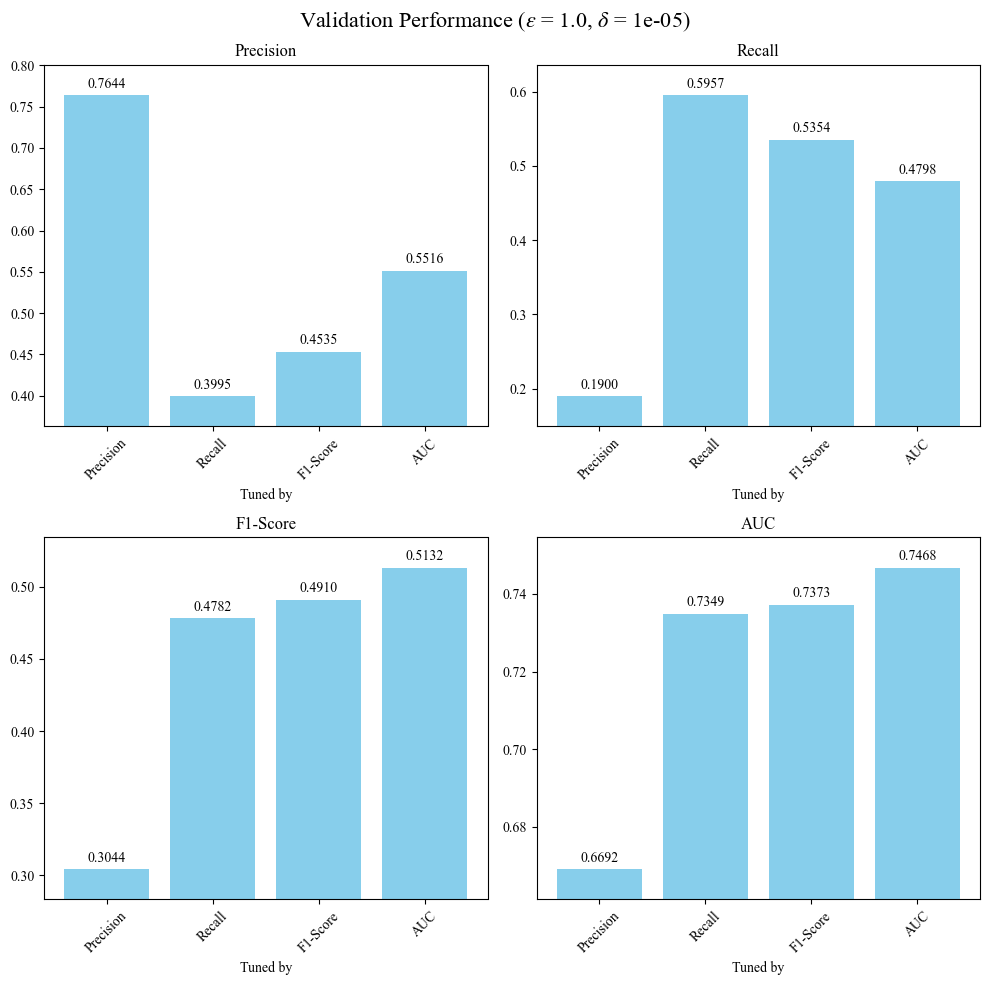

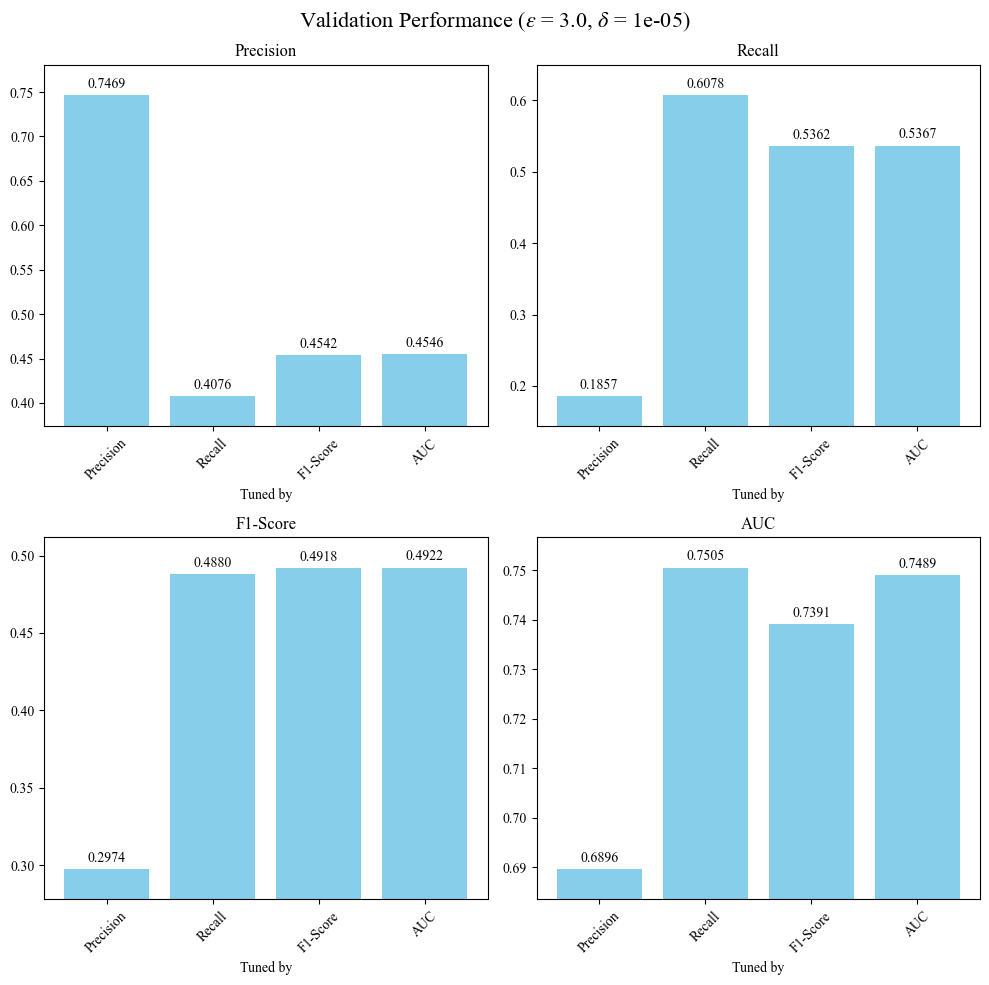

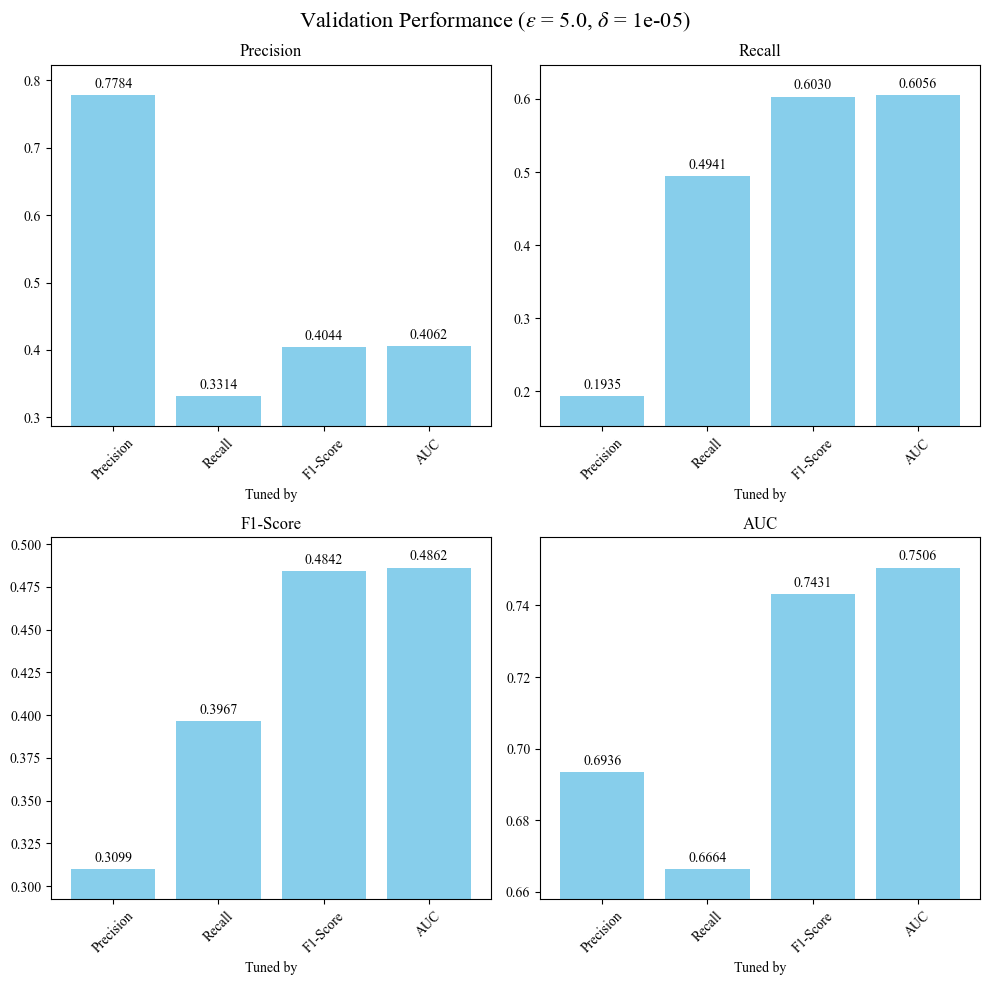

In [9]:
##################################################
## Plot a barplot of the validation performance ##
##################################################

valeval.plot_bar(eval_results, save=False)

### 3.4. Inspect Convergence of Bayesian Optimization

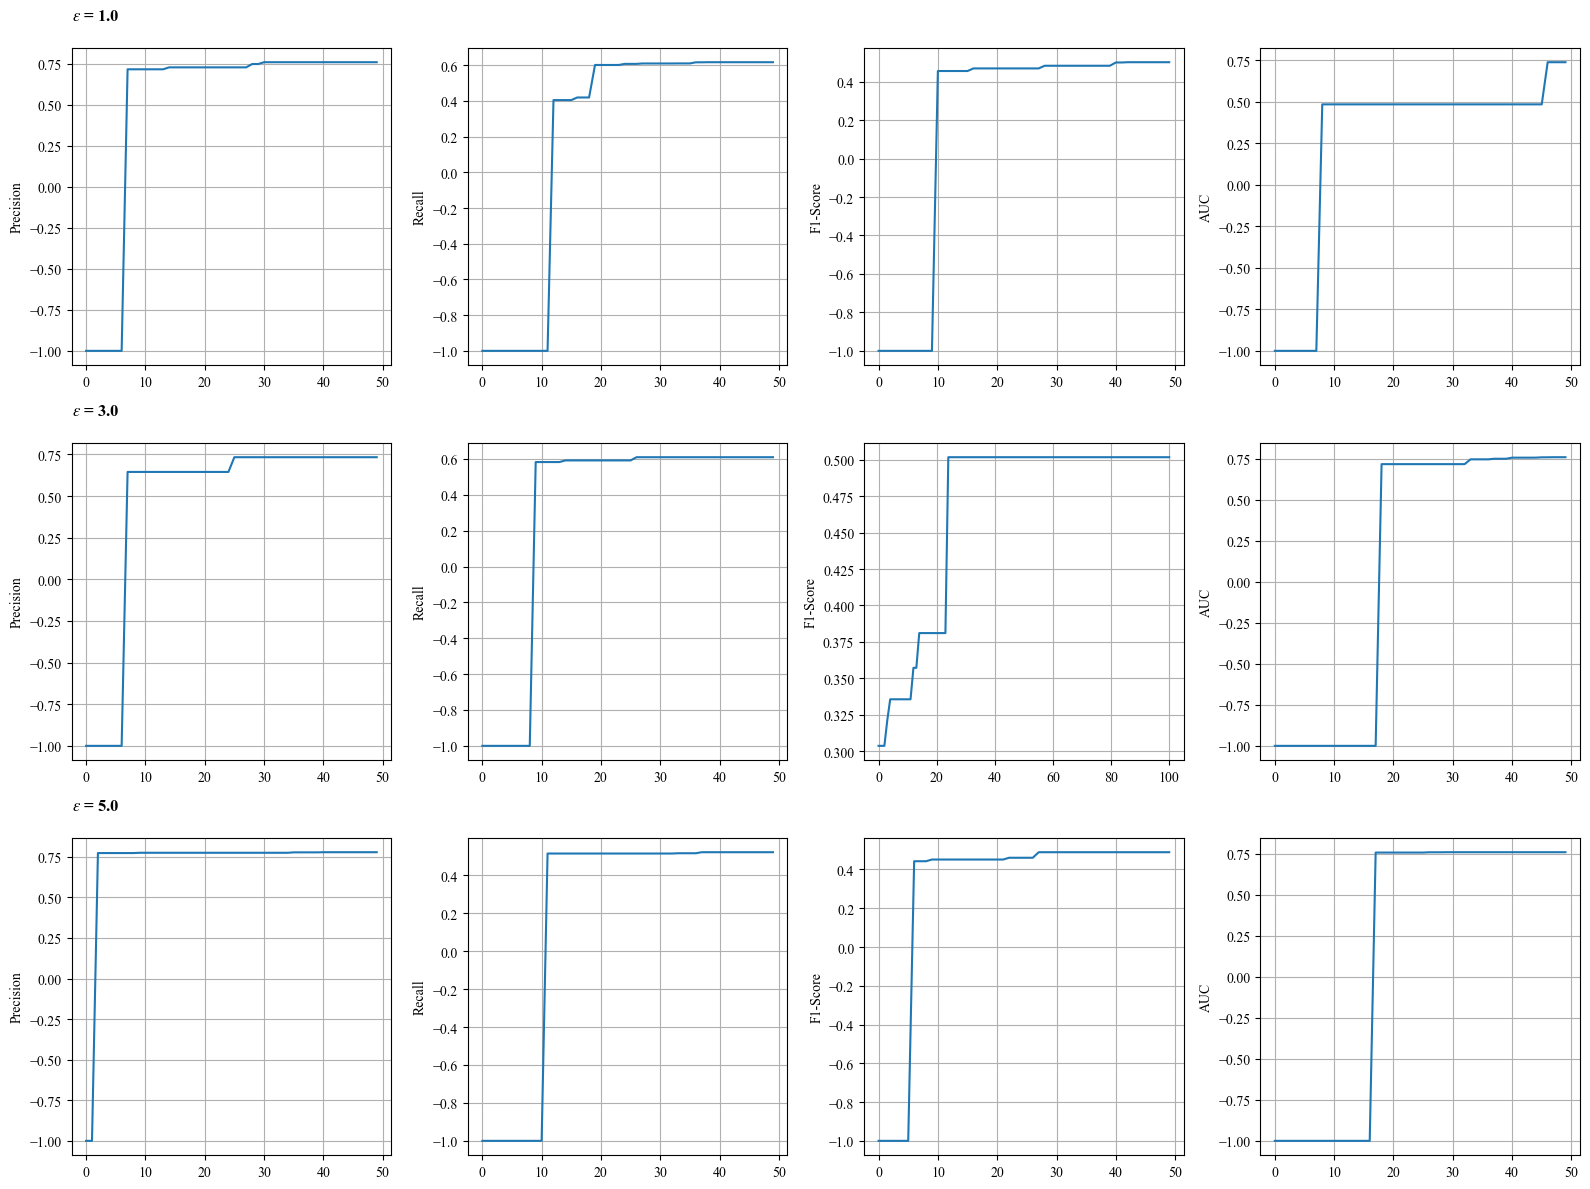

In [10]:
# Sort and reset index for consistent iteration
sorted_results = eval_results.sort_values(by=["epsilon"], ascending=True).reset_index()

# Set up grid
n_cols = 4
n_rows = math.ceil(len(sorted_results) / n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

# Track previous epsilon for row titles
row_epsilons = []

for i, row in sorted_results.iterrows():
    ax = axes[i]
    metric = row["tuned_by"].lower().replace("-", "_")
    version = row["version"]
    epsilon = row["epsilon"]

    # Read result file
    results_df = pd.read_csv(f"../experiments/hyperparam_tune/dpsgd/bayes_{metric}_{version}.csv")
    results_df["best_so_far"] = results_df[metric].cummax()

    # Plot
    ax.plot(results_df.index, results_df["best_so_far"])
    ax.set_ylabel(row["tuned_by"])
    ax.grid(True)

    # If it's the first column in a row, set a title for that row
    if i % n_cols == 0:
        ax.set_title(f"$\\varepsilon$ = {epsilon}", loc='left', fontsize=12, fontweight='bold', pad=20)

# Hide unused subplots if total is not a multiple of n_cols
for j in range(len(sorted_results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 3.5. Check Convergence of the Final Training

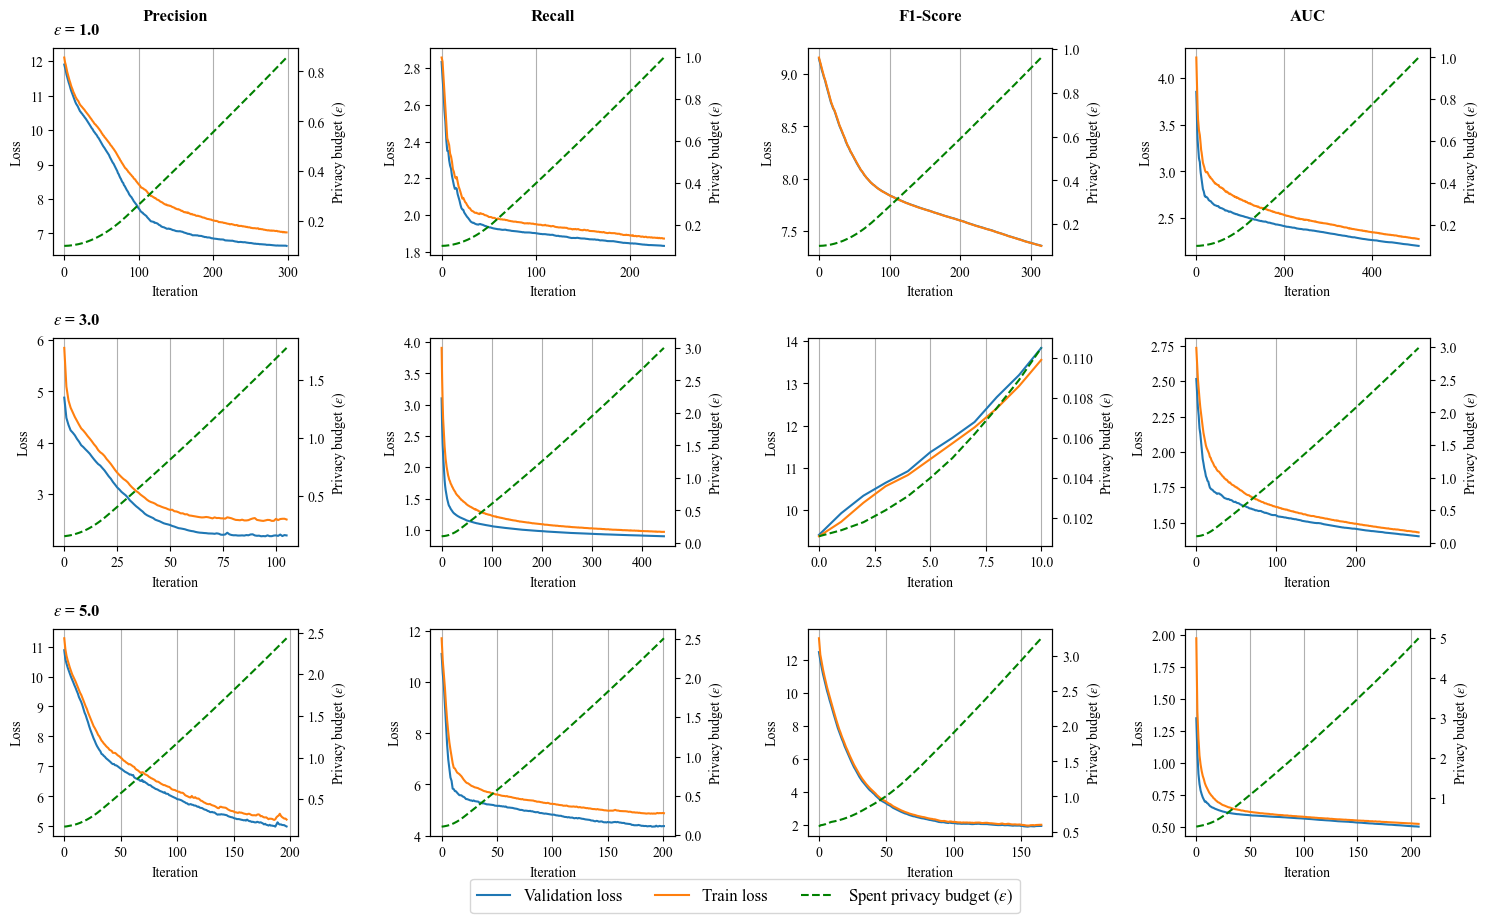

In [11]:
# Sort and reset index for consistent iteration
sorted_results = eval_results.sort_values(by=["epsilon"], ascending=True).reset_index()

# Set up grid
n_cols = 4
n_rows = math.ceil(len(sorted_results) / n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

# Track previous epsilon for row titles
row_epsilons = []

for i, row in sorted_results.iterrows():
    ax1 = axes[i]
    # Create second y-axis sharing the same x-axis
    ax2 = ax1.twinx()
    version = row["version"]
    epsilon = row["epsilon"]
    metric = row["tuned_by"]

    # Read result file
    folder = "../experiments/tracking"

    # Read the existing files with the same version prefix
    pattern = os.path.join(folder, f"{version}_noise*.csv")
    for file in glob.glob(pattern):
        results_df = pd.read_csv(file)

    # Plot loss on the left y-axis
    val = ax1.plot(results_df.index, results_df["val_loss"], label='Validation loss')
    train = ax1.plot(results_df.index, results_df["train_loss"], label='Train loss')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.tick_params(axis='y')

    # Plot epsilon on the right y-axis
    priv = ax2.plot(results_df.index, results_df["spent_eps"], label=r'Spent privacy budget ($\varepsilon$)', color='g', linestyle='--')
    ax2.set_ylabel(r'Privacy budget ($\varepsilon$)')
    ax2.tick_params(axis='y')

    # added these three lines
    lns = val + train + priv
    labs = [l.get_label() for l in lns]
    
    # Set grid for x-axis
    ax1.grid(True, axis='x')

    # Set a title specific to each subplot
    if i // n_cols == 0:
        ax2.set_title(f"{metric}", fontsize=12, pad=20, fontweight='bold')

    # If it's the first column in a row, set a title for that row
    if i % n_cols == 0:
        ax1.set_title(f"$\\varepsilon$ = {epsilon}", loc='left', fontsize=12, fontweight='bold', pad=10)

# Hide unused subplots if total is not a multiple of n_cols
for j in range(len(sorted_results), len(axes)):
    fig.delaxes(axes[j])

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(lns, labs, loc='lower center', bbox_to_anchor=(0.5, -0.03),
           ncol=3, fontsize=12)

plt.tight_layout()
plt.show()